# Modèle Naïf

## Objectif

L'objectif de ce notebook est double. Premièrement, pour plus de simplicité, nous ferons un fichier `predictions.csv` qui répérotiera toutes les prédictions des modèles à venir. Ce .csv sera le même que format que `data_full_preprocessed.csv` en ajoutant une colonne pour chaque modèle avec les prédictions pour éviter le poids du fichier `data_optimized.csv`.

Le second objectif de ce notebook est d'établir les prédictions naïves qui serviront de baseline à nos différents modèles.

## Import des librairies

In [1]:
import os  # for path dirs and files
import tqdm  # progress bar


# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

from dataset import Dataset

## Import du dataset

Dans le notebook précédent numéro 3, nous avons créé une classe dataset pour simplifier les traitement. On peut donc l'importer.

In [2]:
# import the dataset
dataset = Dataset(os.path.join('.', 'data', 'data_optimized.csv'))
print(f'\nLength of the full dataset: {len(dataset)}\n')

# split the dataset
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Training part: {len(training_dataset)}')
print(f'Validation part: {len(validation_dataset)}')
print(f'Test part: {len(test_dataset)}')

Import file...
Convert day to date...
Convert columns to list...

Length of the full dataset: 225208

Training part: 25647
Validation part: 23817
Test part: 159839


## Modèle Naïf

Le modèle naïf est le modèles qui considère que le taux de retour est le même d'une journée à l'autre. 
Donc la prédiction à $t_{0}$ est la valeur du taux de retour à $t_{-1}$.

In [3]:
class NaiveModel:
    
    def __init__(self):
        # give a name to the model
        self.name = 'naive'
    
    def __call__(self, X):
        # prediction on the feature
        pred = X[-1]
        return pred
        
    def _predict_row(self, row):
        
        # predict the row only if it is not Nan of course
        if row.look_back_days != row.look_back_days:
            return np.nan
        else:
            return self.__call__(row.look_back_days)
        
    def predict_all_dataset(self, dataset, progress_bar=True):
        
        # get the primary keys (pair and day) and info (return and set) from the dataset
        predictions_df = pd.DataFrame(dataset.df[['pair', 'day', 'return', 'set']])
        
        # run the prediction all along the dataset and return it as a dataframe of predictions
        if progress_bar:
            tqdm.tqdm.pandas()
            predictions_df[self.name] = dataset.df.progress_apply(self._predict_row, axis=1)
        else:
            predictions_df[self.name] = dataset.df.apply(self._predict_row, axis=1)
            
        return predictions_df
            
        
        
model = NaiveModel()

On a donc pas besoin de l'entrainer ou de l'hyperparamétrer sur le jeu training ou validation. Donc on peut directement faire la prédiciton sur le dataset au complet.

## Prédiction sur tout le dataset et analyse

Pour le moment nous n'avons pas le fichier `results.csv` donc on utilisera uniquement les données issues du dataset. Pour les prochains modèles il faudra merger avec `results.csv` pour ajouter la nouvelle colonne.

On récupère les données.

In [4]:
predictions_df = model.predict_all_dataset(dataset)
predictions_df

C:\Users\athevenot\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████████████████████████████████████████████| 225208/225208 [00:15<00:00, 14774.69it/s]


,pair,day,return,set,naive
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN
...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113


Il est intéressant de noter la distribution des données. En l'occurence, puisqu'il s'agit d'un modèle naïf, on peut largement supposer que la répartition des prédiction sera centrée tout autant que la répartition des valeurs à $t_{-1}$. Ce n'est donc pas un plot très intéressant pour le moment mais il aura sont intérêt pour interpréter les résultats des autres modèles par la suite.

On commence par se créer une fonction qui nous servira pour les notebook suivants. 

In [5]:
def plot_scatter_and_hist(predictions_df, filter_set=None, color='#0593ba', label='', axes=None):

    # definition for set(s) to plot    
    if filter_set is not None: # no filter
        if isinstance(filter_set, str): # convert to list if it is string to be homogeneous
            filter_set = [filter_set]
        # make the filter on the set(s)
        predictions_df = predictions_df[predictions_df['set'].isin(filter_set)]
    # drop Nan values 
    predictions_df = predictions_df.dropna()

    # definitions for the axes
    if axes is None:
        # set the axes dimensions
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        spacing = 0.005
        
        # compute their rectangle
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 0.2]
        rect_histy = [left + width + spacing, bottom, 0.2, height]
        ax_scatter = plt.axes(rect_scatter)
        
        # create the axes
        ax_scatter.tick_params(direction='in', top=True, right=True)
        ax_histx = plt.axes(rect_histx)
        ax_histy = plt.axes(rect_histy)
        ax_histx.tick_params(direction='in', labelbottom=False)
        ax_histy.tick_params(direction='in', labelleft=False)
        
        ax_scatter.set_xlabel('True')
        ax_scatter.set_ylabel('Prediction')
        
        # add the zero's lines to be more comprehensive
        ax_scatter.axvline(x=0, color='#000000', alpha=0.3)
        ax_scatter.axhline(y=0, color='#000000', alpha=0.3)
        ax_histx.axvline(  x=0, color='#000000', alpha=0.3)
        ax_histy.axhline(  y=0, color='#000000', alpha=0.3)
    else:
        ax_scatter, ax_histx, ax_histy = axes
        

    # the scatter plot
    ax_scatter.scatter(predictions_df['return'], predictions_df[model.name], color=color, alpha=0.01)
    
    # the histograms
    bins = 100
    ax_histx.hist(predictions_df['return'], bins=bins, density=True, color=color, alpha=0.3, label=label)
    ax_histy.hist(predictions_df[model.name], bins=bins, density=True, color=color, alpha=0.3, orientation='horizontal')
    
    # set the limit on histograms to have its axis aligned to the scatter plot
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    return ax_scatter, ax_histx, ax_histy
    

Maintenant on peut afficher la distribution des prédictions en fonction des ground truth 

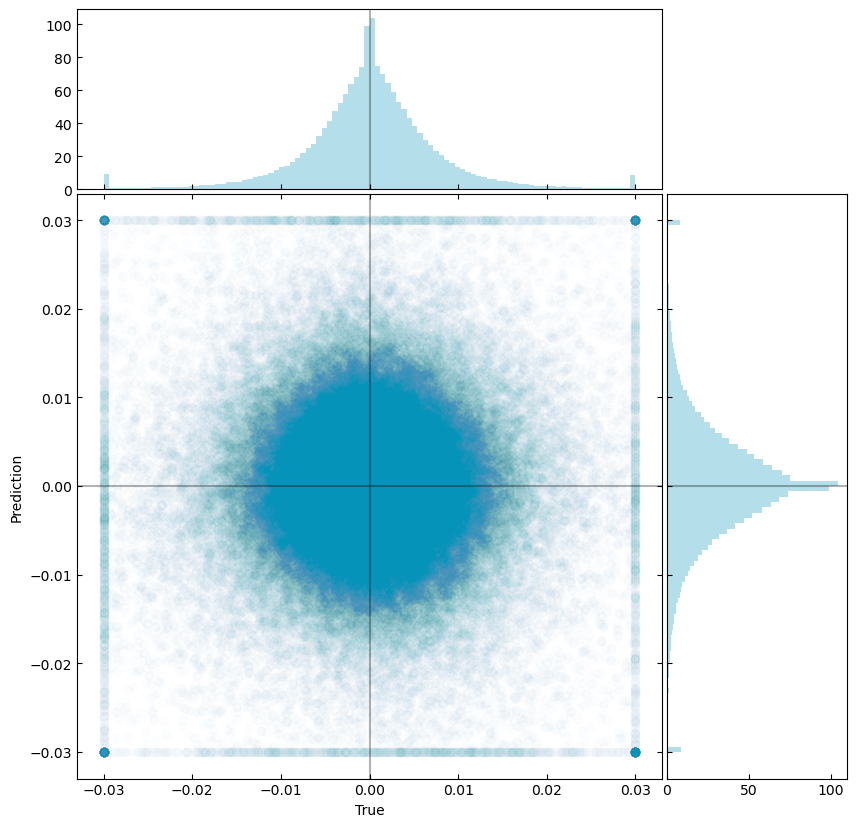

In [6]:
plt.rcParams['figure.figsize'] = [9, 9]    
plot_scatter_and_hist(predictions_df)
plt.rcParams['figure.figsize'] = [12, 4]

pass

Autre chose: il est pertinent de visualiser si la distribution des erreurs est normale ou non. Du moins, vérifier si elle est centrée en zéro et interpréter sont applatissement.
Encore une fois, $\hat{R_{0}} = R_{-1}$ donc cela n'a pas grand intérêt pour l'heure.

A noter que l'erreur est donnée par la formule suivante:

$error = \hat{R_{0}} - R_{0}$

C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


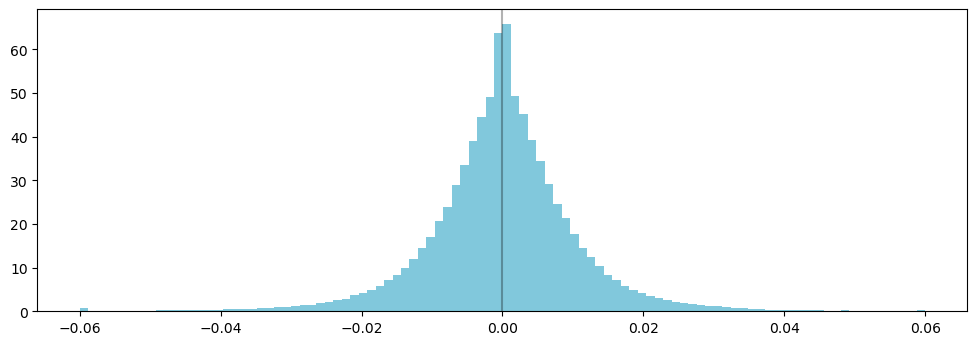

In [7]:
error = predictions_df[model.name] - predictions_df['return']
plt.hist(error, bins=100, density=True, color='#0593ba', alpha=0.5)
plt.axvline(x=0, color='#000000', alpha=0.3)

pass

Mais on peut surtout analyser l'erreur avec des métriques statistiques

In [8]:
pd.options.display.float_format = '{:.8f}'.format
error_table = error.agg(['mean', 'std', 'skew', 'kurt']).reset_index()
error_table

,index,0
0,mean,0.00000058
1,std,0.01067103
2,skew,-0.11430226
3,kurt,4.09804345


In [9]:
set_df = predictions_df[['set']]
set_df['error'] = error
pd.options.display.float_format = "{0:.8f}".format
error_table = set_df.groupby(['set']).agg({'error':['mean', 'std', pd.Series.skew, pd.Series.kurt]}).reset_index()
error_table

<ipython-input-9-f608eb69fba6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_df['error'] = error


set       error                                  
                        mean        std        skew       kurt
0           test  0.00000079 0.01124978 -0.11296780 3.86719170
1       training -0.00000040 0.00856193 -0.09010902 2.74364678
2  unpredictable         nan        nan         nan        nan
3     validation  0.00000021 0.00850976 -0.13065199 4.14000408

In [10]:
pd.options.display.float_format = None

A des fins d'interprétation des métriques statistiques je vous propose ces courtes citations qui résument bien l'interprétation qu'on peut en faire. Autrement dit, l'erreur est d'autant plus optimale que le kurtosis est maximal et, la moyenne, l'écart-type et l'asymétrie minimales.

**English Version**

<blockquote>
"Skewness assesses the extent to which a variable’s distribution is symmetrical. If the distribution of responses for a variable stretches toward the right or left tail of the distribution, then the distribution is referred to as skewed. Kurtosis is a measure of whether the distribution is too peaked (a very narrow distribution with most of the responses in the center)." (Hair et al., 2017, p. 61).
</blockquote>
<blockquote>
"When both skewness and kurtosis are zero (a situation that researchers are very unlikely to ever encounter), the pattern of responses is considered a normal distribution. A general guideline for skewness is that if the number is greater than +1 or lower than –1, this is an indication of a substantially skewed distribution. For kurtosis, the general guideline is that if the number is greater than +1, the distribution is too peaked. Likewise, a kurtosis of less than –1 indicates a distribution that is too flat. Distributions exhibiting skewness and/or kurtosis that exceed these guidelines are considered nonnormal." (Hair et al., 2017, p. 61).
</blockquote>
    
**Version Française**

<blockquote>
"L'asymétrie évalue la mesure dans laquelle la distribution d'une variable est symétrique. Si la distribution des réponses pour une variable s'étend vers la queue droite ou gauche de la distribution, alors la distribution est dite asymétrique. Le kurtosis est une mesure permettant de savoir si la distribution est trop pointue (une distribution très étroite avec la plupart des réponses au centre). " (Hair et al., 2017, p. 61).
</blockquote>
<blockquote>
" Lorsque l'asymétrie et l'aplatissement sont tous deux égaux à zéro (une situation que les chercheurs ont très peu de chances de rencontrer un jour), le modèle de réponses est considéré comme une distribution normale. Une ligne directrice générale pour l'asymétrie est que si le nombre est supérieur à +1 ou inférieur à -1, cela indique une distribution sensiblement asymétrique. Pour l'aplatissement, la ligne directrice générale est que si le nombre est supérieur à +1, la distribution est trop pointue. De même, un aplatissement inférieur à -1 indique une distribution trop plate. Les distributions présentant une asymétrie et/ou un aplatissement qui dépassent ces lignes directrices sont considérées comme non normales. " (Hair et al., 2017, p. 61).
</blockquote>


## Sauvegarde des données

In [11]:
predictions_df.to_csv(os.path.join('.', 'data', 'results.csv'), index=False)

## Sanity check

In [12]:
df = pd.read_csv(os.path.join('.', 'data', 'results.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                       # convert the str days to dates
df

,pair,day,return,set,naive
0,AUDCAD,2007-10-23,0.007541,unpredictable,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,NaN
...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,0.004251
225204,ZARJPY,2020-12-28,0.004670,test,-0.002822
225205,ZARJPY,2020-12-29,-0.002113,test,0.004670
225206,ZARJPY,2020-12-30,-0.006775,test,-0.002113
